In [2]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from cauchy_fit import CauchyFit
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt
import imageio.v2 as imageio

Class ThinFilmLayer

In [6]:
class ThinFilmLayer:
    """
    Class to represent a single layer in a thin film system.
    It encapsulates the layer's index of refraction 'n', extinction coefficient 'k', 
    and thickness. n and k vary with wavelength.
    """
    
    @staticmethod
    def find_file_insensitive(path, filename):
        """
        Search for a file in the specified path in a case-insensitive manner.

        Parameters:
        path : str
            The directory path where to look for the file.
        filename : str
            The name of the file to look for.

        Returns:
        str or None
            The name of the file with the original case if found, None otherwise.
        """
        filename_lower = filename.lower()
        for file in os.listdir(path):
            if file.lower() == filename_lower:
                return file
        return None

    def __init__(self, material, thickness, n_points, min_wavelength, max_wavelength):
        """
        Initialize the layer with the chosen material's properties.
        
        Parameters:
        material : str
            Name of the material where its n, k are extracted.
        thickness : float
            Thickness of the material chosen [nm].
        n_points: int
            Number of points for spline fitting.
            If n_points == 0, then use all the n and k data within the wavelength range.
        min_wavelength: float
            Lower bound of the wavelength used to fit for n and k.
        max_wavelength: float
            Upper bound of the wavelength used to fit for n and k.
        """
        self.material = material
        self.thickness = thickness
        
        # check if a file with material name exists
        path = "database_nk"
        filename = self.find_file_insensitive(path, f"{material}.csv")
        if filename is not None:
            # if yes, read the file
            data = pd.read_csv(os.path.join(path, filename))
            print(f"nk data found for {material}.")
            
            photon_energy = data.iloc[:, 0].values
            wavelength = 1239.8419843320021 / photon_energy # an array of wavelengths
            n = data.iloc[:, 1].values
            k = data.iloc[:, 2].values

            # Sort wavelength, n, and k in ascending order for spline fitting
            sorted_indices = np.argsort(wavelength)
            wavelength = wavelength[sorted_indices]
            n = n[sorted_indices]
            k = k[sorted_indices]

        else:
            # if the file does not exist, generate n and k
            wavelength = np.linspace(min_wavelength, max_wavelength, n_points)
            n = np.random.uniform(1.4, 2.0, n_points)
            k = np.random.uniform(0.0, 0.2, n_points)
            print(f"nk data not found for {material}.")

        # Filtering the data based on wavelength range before creating the spline representation
        indices = (wavelength >= min_wavelength) & (wavelength <= max_wavelength)
        wavelength = wavelength[indices]
        n = n[indices]
        k = k[indices]

        # If n_points != 0, select n points with approximately equal spacing in the wavelength range
        # (If n_points == 0, use all the data points)
        if n_points != 0:
            indices = np.round(np.linspace(0, len(wavelength) - 1, n_points)).astype(int)
            wavelength = wavelength[indices]
            n = n[indices]
            k = k[indices]

        self.wavelength = wavelength
        self.n = n
        self.k = k
        
        # Generate spline representation of n and k
        # if len(wavelength) < 4: # Linear interpolation
        #     self.n_spline = mySpline.fit_spline(wavelength, n, opts=1)
        #     self.k_spline = mySpline.fit_spline(wavelength, k, opts=1)
        # Cubic spline interpolation
        self.n_spline_cubic = CubicSpline(wavelength, n)
        self.k_spline_cubic = CubicSpline(wavelength, k)

        # Univariate spline interpolation
        # self.n_spline_univariate = UnivariateSpline(wavelength, n, k=3)
        # self.k_spline_univariate = UnivariateSpline(wavelength, k, k=3)
        
        # B-spline interpolation
        # self.n_spline_Bspline = BSpline(wavelength, n, k=3)
        # self.k_spline_Bspline = BSpline(wavelength, k, k=3)

        # Cauchy
        # self.n_cauchy = CauchyFit(wavelength, n)
        # self.k_cauchy = CauchyFit(wavelength, k)

        # Self defined
        # self.n_linspace = np.linspace(0, 5, 1000)
        # self.k_linspace = np.linspace(0, 5, 1000)

    def get_n(self, wavelength):
        """
        Returns the index of refraction at the specified wavelength using spline interpolation.

        Parameter:
        wavelength : float
            The wavelength [nm] at which to get the index of refraction.
        """
        n_value = self.n_spline_cubic(wavelength)
        return np.maximum(n_value, 0)

    def get_k(self, wavelength):
        """
        Returns the extinction coefficient at the specified wavelength using spline interpolation.

        Parameter:
        wavelength : float
            The wavelength [nm] at which to get the extinction coefficient.
        """
        k_value = self.k_spline_cubic(wavelength)
        return np.maximum(k_value, 0)
    
    def get_N(self, wavelength):
        """
        Returns the refractive index at the specified wavelength using spline interpolation.

        Parameter:
        wavelength : float
            The wavelength [nm] at which to get the refractive index.
        """
        return self.get_n(wavelength) + 1j * self.get_k(wavelength)

    def set_n(self, wavelength, new_n_value):
        """
        Sets the refractive index at the specified wavelength and updates the spline representation.

        Parameters:
        wavelength : float
            The wavelength [nm] at which to set the index of refraction.
        new_n_value : float
            The new index of refraction value.
        """
        idx = (np.abs(self.wavelength - wavelength)).argmin()  # find the closest wavelength
        self.n[idx] = new_n_value

        # Update the spline representation
        # if len(self.wavelength) < 4:
        #     self.n_spline = make_interp_spline(self.wavelength, self.n, k=1)
        # else:
        original_n_spline_cubic = CubicSpline(self.wavelength, self.n)
        self.n_spline_cubic = lambda x: np.maximum(original_n_spline_cubic(x), 0)


    def set_k(self, wavelength, new_k_value):
        """
        Sets the extinction coefficient at the specified wavelength and updates the spline representation.
        
        Parameters:
        wavelength : float
            The wavelength [nm] at which to set the extinction coefficient.
        new_k_value : float
            The new extinction coefficient value.
        """
        idx = (np.abs(self.wavelength - wavelength)).argmin()  # find the closest wavelength
        self.k[idx] = new_k_value

        # Update the spline representation
        # if len(self.wavelength) < 4:
        #     self.k_spline = make_interp_spline(self.wavelength, self.k, k=1)
        # else:
        original_k_spline_cubic = CubicSpline(self.wavelength, self.k)
        self.k_spline_cubic = lambda x: np.maximum(original_k_spline_cubic(x), 0)


    def plot_n(self, min_wavelength, max_wavelength):
        """
        Plots the index of refraction as a function of wavelength.
        """
        wavelengths = np.linspace(min_wavelength, max_wavelength, num=1000)
        plt.figure()
        plt.plot(wavelengths, self.n_spline_cubic(wavelengths), '-', label='n spline cubic')
        # plt.plot(wavelengths, self.n_spline_univariate(wavelengths), '-', label='n spline univariate')
        # plt.plot(wavelengths, self.n_spline_Bspline(wavelengths), '-', label='n spline Bspline')
        # plt.plot(wavelengths, self.n_cauchy(wavelengths), '-', label='n spline cauchy')
        plt.scatter(self.wavelength, self.n, marker='o', color='r', label='n data')
        plt.xlabel('Wavelength (λ) [nm]')
        plt.ylabel('Refractive index (n)')
        plt.title(f'Refractive index (n) vs wavelength for {self.material}')
        plt.legend()
        plt.show()

    def plot_k(self, min_wavelength, max_wavelength):
        """
        Plots the extinction coefficient as a function of wavelength.
        """
        wavelengths = np.linspace(min_wavelength, max_wavelength, num=1000)
        plt.figure()
        plt.plot(wavelengths, self.k_spline_cubic(wavelengths), '-', label='k spline cubic')
        # plt.plot(wavelengths, self.k_spline_univariate(wavelengths), '-', label='k spline univariate')
        # plt.plot(wavelengths, self.k_spline_Bspline(wavelengths), '-', label='k spline Bspline')
        # plt.plot(wavelengths, self.k_cauchy(wavelengths), '-', label='n spline cauchy')
        plt.scatter(self.wavelength, self.k, marker='o', color='r', label='k data')
        plt.xlabel('Wavelength (λ) [nm]')
        plt.ylabel('Extinction coefficient (k)')
        plt.title(f'Extinction coefficient (k) vs wavelength for {self.material}')
        plt.legend()
        plt.show()

    def plot_nk(self, min_wavelength, max_wavelength):
        """
        Plots the index of refraction and extinction coefficient as functions of wavelength,
        both for the input data and the spline interpolation.
        """
        wavelengths = np.linspace(min_wavelength, max_wavelength, num=1000)
        n_values = self.n_spline_cubic(wavelengths)
        k_values = self.k_spline_cubic(wavelengths)

        fig, ax1 = plt.subplots()

        ax1.set_xlabel('Wavelength (λ) [nm]')
        ax1.set_ylabel('Refractive index (n)', color='tab:blue')
        ax1.plot(wavelengths, n_values, '-', color='tab:blue', label='n spline')
        ax1.scatter(self.wavelength, self.n, marker='o', color='r', label='n data')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()  
        ax2.set_ylabel('Extinction coefficient (k)', color='tab:red')  
        ax2.plot(wavelengths, k_values, '-', color='tab:red', label='k spline')
        ax2.scatter(self.wavelength, self.k, marker='o', color='r', label='k data')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        fig.tight_layout()  
        plt.title(f'Refractive index and extinction coefficient vs wavelength for {self.material}')
        fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
        plt.show()

In [7]:
class FakeThinFilmLayer:
    def __init__(self, thickness, n, k):
        self.thickness = thickness
        self.n = n
        self.k = k
    
    def get_N(self, wavelength):
        return self.n + 1j * self.k

    def set_n(self, n):
        self.n = n

    def set_k(self, k):
        self.k = k

Class ThinFilmSystem

In [8]:
class ThinFilmSystem:
    """
    Class to represent a thin film system composed of multiple layers.
    """
    def __init__(self, layers):
        """
        Initialize the system with a list of ThinFilmLayer objects.
        layers : list of ThinFilmLayer
            Layers of the system in order from the top layer to the substrate.
        """
        self.layers = layers

    def add_layer(self, layer):
        """
        Add a layer to the system. The new layer is added to the top of the stack.

        Parameters:
        layer : ThinFilmLayer
            The layer to add. This should be an instance of the ThinFilmLayer class.
        """
        self.layers.insert(0, layer)
    
    def calculate_propagation_matrix(self, wavelength, layer_index):
        """
        Calculate the propagation matrix for this layer for a particular wavelength.
        Assume the incident light is normal (or the calculation would be very complicated...)
        Can add the non-normal part later using Snell's law: N1cos(θ1) = N2cos(θ2)

        Parameters:
        wavelength : float
            Wavelength [nm] at which to calculate the propagation matrix of this layer.
        layer_index: int
            Index of the layer to be calculated in the multilayer system.

        Returns:
        P : 2D array
            Propagation matrix of this layer.
        """
        N = self.layers[layer_index].get_N(wavelength)
        thickness = self.layers[layer_index].thickness
        phase = 2 * np.pi * N * thickness / wavelength
        P = np.array([[np.exp(1j * phase.real) * np.exp(-phase.imag), 0], 
                      [0, np.exp(-1j * phase.real) * np.exp(phase.imag)]])
        return P
    
    def calculate_boundary_matrix(self, wavelength, layer_index):
        """
        Calculate the boundary matrix for two adjacent layers ("this" layer and "next" layer) 
        in the multilayer system for a particular wavelength.
        Assume the incident light is normal (or the calculation would be very complicated...)
        Can add the non-normal part later using Snell's law: N1cos(θ1) = N2cos(θ2)

        Parameters:
        wavelength : float
            Wavelength [nm] at which to calculate the boundary matrix of this layer.
        layer_index: int
            Index of the layer to be calculated in the multilayer system.
        
        Returns:
        B : 2D array
            Boundary matrix of the boundary between this layer and the next layer.
        """
        N_this = self.layers[layer_index].get_N(wavelength)
        N_next = self.layers[layer_index + 1].get_N(wavelength)
        B = 1 / (2 * N_this) * np.array([[N_this + N_next, N_this - N_next],
                                         [N_this - N_next, N_this + N_next]])
        B = np.conjugate(B)
        return B
    
    def calculate_total_transfer_matrix(self, wavelength):
        """
        Calculate the total transfer matrix for the multilayer system 
        for a particular wavelength.
        Assume the incident light is normal (or the calculation would be very complicated...)
        Can add the non-normal part later using Snell's law: N1cos(θ1) = N2cos(θ2)

        Parameters:
        wavelength : float
            Wavelength [nm] at which to calculate the transfer matrix of this layer.
        
        Returns:
        M_total : 2D array
            Total transfer matrix of the multilayer system.
        """
        M = np.eye(2) # create an identity matrix
        B01 = self.calculate_boundary_matrix(wavelength, 0) # The boundary matrix between air and the first layer
        M = M @ B01
        for index in range(1, len(self.layers) - 1):
            P = self.calculate_propagation_matrix(wavelength, index)
            B = self.calculate_boundary_matrix(wavelength, index)
            M = M @ P @ B
        return M
    
    def print_matrices(self, wavelength):
        """
        Print the boundary matrices, propagation matrices, and their multiplications for the multilayer system 
        for a particular wavelength.

        Parameter:
        wavelength: float
            Wavelength of the light at which matrices are printed.
        """
        # Print the boundary matrix between air and the first layer
        B01 = self.calculate_boundary_matrix(wavelength, 0)
        print(f"B01 = {B01}")

        # Print the matrices for the rest layers, and their multiplication
        M = np.eye(2) # create an identity matrix
        M = B01 @ M
        print(f"M = {M}")

        for index in range(1, len(self.layers) - 1):
            P = self.calculate_propagation_matrix(wavelength, index)
            print(f"P{index} = {P}")
            M = M @ P
            print(f"M = {M}")
            B = self.calculate_boundary_matrix(wavelength, index)
            print(f"B{index}{index + 1} = {B}")
            M = M @ B
            print(f"M = {M}")
            M_cal = self.calculate_total_transfer_matrix(wavelength)
            print(f"M_cal = {M_cal}")

    def print_N(self, wavelength):
        """
        Print N for each layer in the multilayer system.
        
        Parameter:
        wavelength: float
            Wavelength of the light at which N are calculated and printed.
        """
        for layer in self.layers:
            index = self.layers.index(layer)
            print(f"N_{index} = {layer.get_N(wavelength)}")

    def calculate_RTA(self, wavelength_range):
        """
        Calculate the reflectance (R), transmittance (T), and absorption (A)
        for a multilayer system as a function of wavelength.
        Assume the incident light is normal (or the calculation would be very complicated...)
        Can add the non-normal part later using Snell's law: N1cos(θ1) = N2cos(θ2)
        
        Parameters:
        wavelength_range : array-like
            Range of wavelengths [nm] for which R, T, A should be calculated.
        
        Returns:
        R : array-like
            Reflectance of the multilayer system for each wavelength in wavelength_range.
        T : array-like
            Transmittance of the multilayer system for each wavelength in wavelength_range.
        A : array-like
            Absorption of the multilayer system for each wavelength in wavelength_range.
        """
        R = []
        T = []
        A = []
        for wavelength in wavelength_range:
            M = self.calculate_total_transfer_matrix(wavelength)
            # Calculate R
            r = M[1, 0] / M[0, 0]
            R_value = np.abs(r)**2
            R.append(np.clip(R_value, 0, 1)) # np.clip is used to restrict the value within [0, 1]

            # Calculate T
            n0 = self.layers[0].get_n(wavelength) # n of the incident medium, which is usually air
            ns = self.layers[-1].get_n(wavelength) # n of the substrate
            t = 1 / M[0, 0]
            T_value = np.abs(t)**2 * (ns / n0) # (ns / n0) corrects for the index of the substrate
            T.append(np.clip(T_value, 0, 1))

            # Calulate A
            A_value = 1 - R[-1] - T[-1]
            A.append(np.clip(A_value, 0, 1))

        return np.array(R), np.array(T), np.array(A)
    
    def calculate_RTA_single(self, wavelength):
        """
        Calculate the reflectance (R), transmittance (T), and absorption (A)
        for a multilayer system for a single wavelength.

        Parameters:
        wavelength: float
            Wavelength of the light to calculate R, T, A.

        Returns:
        R : float
            Reflectance of the multilayer system for this wavelength.
        T : float
            Transmittance of the multilayer system for this wavelength.
        A : float
            Absorption of the multilayer system for this wavelength.
        """
        M = self.calculate_total_transfer_matrix(wavelength)
        # Calculate R
        r = M[1, 0] / M[0, 0]
        R = np.abs(r)**2
        R = np.clip(R, 0, 1) # np.clip is used to restrict the value within [0, 1]

        # Calculate T
        n0 = self.layers[0].get_n(wavelength) # n of the incident medium, which is usually air
        ns = self.layers[-1].get_n(wavelength) # n of the substrate
        t = 1 / M[0, 0]
        T = np.abs(t)**2 * (ns / n0) # (ns / n0) corrects for the index of the substrate
        T = np.clip(T, 0, 1)

        # Calculate A
        A = 1 - R - T
        A = np.clip(A, 0, 1)

        return R, T, A

    def plot_RTA(self, wavelength_range):
        """
        Plot the reflectance (R), transmittance (T), and absorption (A)
        for the multilayer system as a function of wavelength.
        Assume the incident light is normal.

        Parameters:
        wavelength_range : array-like
            Range of wavelengths [nm] for which R, T, A should be plotted.
        theta_deg : float
            Angle of incidence within the medium [degrees].
        """
        # Calculate RTA
        R, T, A = self.calculate_RTA(wavelength_range)

        # Generate the plot
        plt.figure(figsize=(10, 6))

        plt.plot(wavelength_range, R, label='Reflectance')
        plt.plot(wavelength_range, T, label='Transmittance')
        plt.plot(wavelength_range, A, label='Absorption')

        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Magnitude')
        plt.title('RTA vs Wavelength for Thin Film System')
        plt.legend()
    
    def vary_nk_and_calculate_R(self, layer_index, wavelengths, n_values, k_values):
        """
        Vary the refractive index (n) and extinction coefficient (k) of a specified layer at specified wavelengths,
        calculate the reflectance for each combination of n and k, and return the reflectance values.

        Parameters:
        layer_index : int
            Index of the layer in the system where n and k will be adjusted.
        wavelengths : list of float
            Wavelengths at which to adjust n and k.
        n_values : list of float
            Values of refractive index to try.
        k_values : list of float
            Values of extinction coefficient to try.

        Returns:
        reflectances : list of list of float
            Reflectance of the system for each combination of n and k.
        """
        original_n = [self.layers[layer_index].get_n(wavelength) for wavelength in wavelengths]
        original_k = [self.layers[layer_index].get_k(wavelength) for wavelength in wavelengths]

        reflectances = []
        for n in n_values:
            for k in k_values:
                # Set new n and k for each wavelength
                for wavelength, new_n, new_k in zip(wavelengths, n, k):
                    self.layers[layer_index].set_n(wavelength, new_n)
                    self.layers[layer_index].set_k(wavelength, new_k)

                # Calculate reflectance
                R, _, _ = self.calculate_RTA(wavelengths)
                reflectances.append(R)

                # Reset n and k to original values
                for wavelength, old_n, old_k in zip(wavelengths, original_n, original_k):
                    self.layers[layer_index].set_n(wavelength, old_n)
                    self.layers[layer_index].set_k(wavelength, old_k)

        return reflectances

Create multilayer system

(1) Calculate R for various n, k of layer1

In [6]:
l = 380 # left
r = 830 # right

wavelength_range = [380.32, 439.66, 520.94, 639.09, 826.56]

air = ThinFilmLayer("air", 1, 0, l, r)
layer1 = FakeThinFilmLayer(104.0, 0, 0)
layer2 = ThinFilmLayer("sio2", 21.5, 0, l, r)
substrate = ThinFilmLayer("c-Si", 1, 0, l, r)

# Create multilayer system
multilayer = ThinFilmSystem([air, layer1, layer2, substrate])

n_values = np.linspace(-3, 3, 100)
k_values = np.linspace(-3, 3, 100)

# Create arrays to store the reflectance values
reflectances = np.zeros((len(wavelength_range), len(n_values), len(k_values)))

# Loop over each wavelength
for w, wavelength in enumerate(wavelength_range):
    # Loop over each n and k value
    for i, n in enumerate(n_values):
        for j, k in enumerate(k_values):
            # Set n and k for layer1
            layer1.set_n(n)
            layer1.set_k(k)
            
            # Calculate the reflectance
            R, _, _ = multilayer.calculate_RTA_single(wavelength)
            
            # Store the reflectance value
            reflectances[w, i, j] = R

# Store the experimental reflectance values
experimental_R = np.array([0.113689, 0.425386, 0.451865, 0.280185, 0.089312])

# Create a meshgrid of n and k values
n_values, k_values = np.meshgrid(n_values, k_values)

# Create two arrays to store the optimal n, k
optimal_n = []
optimal_k = []


nk data found for air.
nk data found for sio2.
nk data found for c-Si.


(2) Plot

In [7]:
# # Loop over each wavelength
# for w, wavelength in enumerate(wavelength_range):
#     # Create a new figure for this wavelength
#     fig = plt.figure(figsize=(12, 6))

#     fig.subplots_adjust(wspace=0.3)  # Adjust this value as needed
    
#     # Add a subplot for the reflectance
#     ax1 = fig.add_subplot(121, projection='3d')

#     # Plot the reflectance as a function of n and k
#     surface = ax1.plot_surface(n_values, k_values, reflectances[w], cmap='viridis', alpha=0.6)

#     # Add a plane for the experimental reflectance
#     ax1.plot_surface(n_values, k_values, experimental_R[w]*np.ones_like(reflectances[w]), color='r', alpha=0.3)

#     # Set the title and labels
#     ax1.set_title('Wavelength: {} nm'.format(wavelength))
#     ax1.set_xlabel('n')
#     ax1.set_ylabel('k')
#     ax1.set_zlabel('R_cal')

#     # Set the viewpoint for ax1
#     elevation_angle = 30  # adjust to your preference
#     azimuthal_angle = 225  # adjust to your preference
#     # ax1.view_init(elevation_angle, azimuthal_angle)

#     # Add a subplot for the squared error
#     ax2 = fig.add_subplot(122)

#     # Calculate the error
#     squared_error = (reflectances[w] - experimental_R[w])**2
#     abs_error = np.abs(reflectances[w] - experimental_R[w])

#     # Plot the squared error as a function of n and k
#     # ax2.plot_surface(n_values, k_values, squared_error, cmap='viridis', alpha=0.6)
#     im = ax2.imshow(abs_error, extent=(-3, 3, -3, 3))
#     # Create a colorbar for the heatmap
#     # Get the position of ax2
#     pos = ax2.get_position()

#     # Create a new set of axes for the colorbar at the right of ax2
#     # The arguments to fig.add_axes are [left, bottom, width, height]
#     cbar_ax = fig.add_axes([pos.x1+0.01, pos.y0, 0.02, pos.height])

#     # Create a colorbar in the new axes
#     cbar = fig.colorbar(im, cax=cbar_ax)

#     # Set the label for the colorbar
#     cbar.set_label('Abs(R_cal - R_exp)')

#     # # Find the minimum of the squared error
#     # min_error_idx = np.unravel_index(np.argmin(squared_error, axis=None), squared_error.shape)
#     # min_n = n_values[min_error_idx]
#     # min_k = k_values[min_error_idx]
#     # optimal_n.append(min_n)
#     # optimal_k.append(min_k)
#     # print(f'{wavelength} nm: (n,k) = ({min_n}, {min_k})')

#     # # Plot the minimum error as a red dot and a vertical line
#     # ax2.scatter(min_n, min_k, squared_error[min_error_idx], color='r')
#     # ax2.plot([min_n, min_n], [min_k, min_k], [squared_error[min_error_idx], squared_error.max()], color='r')

#     # Set the title and labels
#     ax2.set_title('Abs Error at Wavelength: {} nm'.format(wavelength))
#     ax2.set_xlabel('n')
#     ax2.set_ylabel('k')
#     # ax2.set_zlabel('Abs Error')

#     # Set the viewpoint for ax2
#     # ax2.view_init(elevation_angle, azimuthal_angle)

#     # Display the plot
#     plt.show()

# # Plot the optimal n, k
# # Create a new figure for the n and k values
# # fig, ax1 = plt.subplots()

# # # Plot the optimal n values
# # ax1.plot(wavelength_range, optimal_n, color='b', label='n')
# # ax1.scatter(wavelength_range, optimal_n, color='b')

# # # Create a second y-axis for the k values
# # ax2 = ax1.twinx()
# # ax2.plot(wavelength_range, optimal_k, color='r', label='k')
# # ax2.scatter(wavelength_range, optimal_k, color='r')

# # Set the title and labels
# # ax1.set_title('Optimal n and k values')
# # ax1.set_xlabel('Wavelength (nm)')
# # ax1.set_ylabel('n', color='b')
# # ax2.set_ylabel('k', color='r')

# # # Add legends
# # ax1.legend(loc='upper left')
# # ax2.legend(loc='upper right')

# # # Display the plot
# # plt.show()

Test if the FakeThinFilmLayer actually works

In [8]:
# # wavelength_range = [380.3196271, 439.66027813, 520.94201022, 639.09380636, 826.56132289]
# # n = [2.18891476, 2.10889382, 2.0642569, 2.03309232, 2.00816669]
# # k = [0.01513064, 0.00027178, 0, 0.00074228, 0.00020019]

# l = 380 # left
# r = 830 # right
# wavelength_range = np.linspace(l, r, 100)

# layer_igzo111 = ThinFilmLayer("igzo_111", 104.0, 10, l, r)
# n = layer_igzo111.get_n(wavelength_range)
# k = layer_igzo111.get_k(wavelength_range)

# air = ThinFilmLayer("air", 1, 0, l, r)
# layer2 = ThinFilmLayer("sio2", 21.5, 0, l, r)
# substrate = ThinFilmLayer("c-Si", 1, 0, l, r)

# R_result = []

# for i in range(len(wavelength_range)):
#     layer1 = FakeThinFilmLayer(104.0, n[i], k[i])
#     multilayer = ThinFilmSystem([air, layer1, layer2, substrate])
#     R, _, _ = multilayer.calculate_RTA_single(wavelength_range[i])
#     R_result.append(R)

# print(R_result)

# plt.figure(figsize=(10, 6))
# plt.scatter(wavelength_range, R_result, c='r')
# plt.xlabel('Wavelength [nm]')
# plt.ylabel('R')
# plt.show()


Try to plot nk heatmap for all wavelengths

In [9]:
# from scipy.ndimage import gaussian_filter1d
# from scipy.signal import medfilt
# import os

# # Process the data
# # =====================================================
# # Load the data
# path = r"test_data\spectra\+02_+05.csv"
# data = pd.read_csv(path, names=['# lambda', 'reflectance', 'uncertainty', 'raw', 'dark', 'reference', 'fit'], skiprows=13)
# data = data.rename(columns={'# lambda': 'wavelength'})

# # Filter data based on wavelength
# data = data[(data['wavelength'] >= 380) & (data['wavelength'] <= 830)]

# # Apply the moving median filter to remove sudden spikes
# kernel_size = 11 # Adjust as needed
# data['reflectance'] = medfilt(data['reflectance'], kernel_size=kernel_size)

# # Apply a Gaussian smoothing
# sigma = 20 # This is the standard deviation for the Gaussian kernel. Adjust as needed.
# smoothed_data = gaussian_filter1d(data['reflectance'], sigma)

# # Choose n points from the smoothed data
# n_points = 100
# indices = np.round(np.linspace(0, len(smoothed_data) - 1, n_points)).astype(int)
# wavelengths_selected = data['wavelength'].iloc[indices].values
# smoothed_data_selected = smoothed_data[indices]
# # =====================================================


# # Calculate reflectance and plot
# # =====================================================
# # Define the directory where you want to save the figure
# dir_name = "plot2"

# # Check if the directory exists, and if it doesn't, create it
# if not os.path.exists(dir_name):
#     os.makedirs(dir_name)

# l = 380
# r = 830

# # Create layers
# air = ThinFilmLayer("air", 1, 0, l, r)
# layer1 = FakeThinFilmLayer(104.0, 0, 0)
# layer2 = ThinFilmLayer("sio2", 21.5, 0, l, r)
# substrate = ThinFilmLayer("c-Si", 1, 0, l, r)

# layer_igzo111 = ThinFilmLayer("igzo_111", 104.0, 10, l, r)
# n = layer_igzo111.get_n(wavelengths_selected)
# k = layer_igzo111.get_k(wavelengths_selected)
# print(n.shape)

# # Create multilayer system
# multilayer = ThinFilmSystem([air, layer1, layer2, substrate])

# n_values = np.linspace(1.5, 2.5, 100)
# k_values = np.linspace(1e-6, 0.02, 100)

# # Create arrays to store the reflectance values
# reflectances = np.zeros((len(wavelengths_selected), len(n_values), len(k_values)))

# # Create a meshgrid of n and k values
# n_values, k_values = np.meshgrid(n_values, k_values)

# # Loop over each wavelength
# for w, wavelength in enumerate(wavelengths_selected):
#     for i in range(n_values.shape[0]):
#         for j in range(n_values.shape[1]):
#             # Set n and k for layer1
#             layer1.set_n(n_values[i, j])
#             layer1.set_k(k_values[i, j])
            
#             # Calculate the reflectance
#             R, _, _ = multilayer.calculate_RTA_single(wavelength)
            
#             # Store the reflectance value
#             reflectances[w, i, j] = R
    
#     # Plot
#     # Create a new figure for this wavelength
#     fig = plt.figure(figsize=(12, 6))

#     fig.subplots_adjust(wspace=0.3)  # Adjust this value as needed
    
#     # Add a subplot for the reflectance
#     ax1 = fig.add_subplot(121, projection='3d')

#     # Plot the reflectance as a function of n and k
#     surface = ax1.plot_surface(n_values, k_values, reflectances[w], cmap='viridis', alpha=0.6)

#     # Add a plane for the experimental reflectance
#     ax1.plot_surface(n_values, k_values, smoothed_data_selected[w]*np.ones_like(reflectances[w]), color='r', alpha=0.3)

#     # Set the title and labels
#     ax1.set_title('Wavelength: {} nm'.format(wavelength))
#     ax1.set_xlabel('n')
#     ax1.set_ylabel('k')
#     ax1.set_zlabel('R_cal')

#     # Set the viewpoint for ax1
#     elevation_angle = 30  # adjust to your preference
#     azimuthal_angle = 225  # adjust to your preference

#     # Add a subplot for the squared error
#     ax2 = fig.add_subplot(122)

#     # Calculate the error
#     abs_error = np.abs(reflectances[w] - smoothed_data_selected[w])

#     # Plot the squared error as a function of n and k
#     im = ax2.imshow(abs_error, extent=(1.5, 2.5, 1e-6, 0.02), aspect='auto')

#     # Plot the (n, k) from database
#     ax2.scatter(n[w], k[w], c='r')

#     # Create a colorbar for the heatmap
#     # Get the position of ax2
#     pos = ax2.get_position()
#     # Create a new set of axes for the colorbar at the right of ax2
#     # The arguments to fig.add_axes are [left, bottom, width, height]
#     cbar_ax = fig.add_axes([pos.x1+0.01, pos.y0, 0.02, pos.height])

#     # Create a colorbar in the new axes
#     cbar = fig.colorbar(im, cax=cbar_ax)

#     # Set the label for the colorbar
#     cbar.set_label('Abs(R_cal - R_exp)')

#     # Set the title and labels
#     ax2.set_title('Abs Error at Wavelength: {} nm'.format(wavelength))
#     ax2.set_xlabel('n')
#     ax2.set_ylabel('k')

#     # save the plot
#     plt.savefig(os.path.join(dir_name, f"{wavelength}.png"))
#     # =====================================================


In [10]:
# # Convert png into video
# import imageio.v2 as imageio
# import os

# # Get the file names from a given directory
# folder_path = "plot2"
# file_names = sorted((fn for fn in os.listdir(folder_path) if fn.endswith('.png')))

# # Create a list of images
# images = [imageio.imread(os.path.join(folder_path, fn)) for fn in file_names]

# # Save the images as a movie
# imageio.mimwrite('movie2.mp4', images, fps=10)  # Adjust FPS as needed


In [9]:
# Process the data
# =====================================================
# Load the data
path = r"test_data\spectra\+02_+05.csv"
data = pd.read_csv(path, names=['# lambda', 'reflectance', 'uncertainty', 'raw', 'dark', 'reference', 'fit'], skiprows=13)
data = data.rename(columns={'# lambda': 'wavelength'})

# Filter data based on wavelength
data = data[(data['wavelength'] >= 380) & (data['wavelength'] <= 830)]

# Apply the moving median filter to remove sudden spikes
kernel_size = 11 # Adjust as needed
data['reflectance'] = medfilt(data['reflectance'], kernel_size=kernel_size)

# Apply a Gaussian smoothing
sigma = 20 # This is the standard deviation for the Gaussian kernel. Adjust as needed.
smoothed_data = gaussian_filter1d(data['reflectance'], sigma)

# Choose n points from the smoothed data
n_points = 100
indices = np.round(np.linspace(0, len(smoothed_data) - 1, n_points)).astype(int)
wavelengths_selected = data['wavelength'].iloc[indices].values
smoothed_data_selected = smoothed_data[indices]

# Define the directory where you want to save the figure
dir_name = "plot3"
# =====================================================


# Define the multilayer system
# =====================================================
l = 380
r = 830

# Create layers
air = ThinFilmLayer("air", 1, 0, l, r)
layer1 = FakeThinFilmLayer(104.0, 0, 0)
layer2 = ThinFilmLayer("sio2", 21.5, 0, l, r)
substrate = ThinFilmLayer("c-Si", 1, 0, l, r)

layer_igzo111 = ThinFilmLayer("igzo_111", 104.0, 10, l, r)
n = layer_igzo111.get_n(wavelengths_selected)
k = layer_igzo111.get_k(wavelengths_selected)
print(n.shape)

# Create multilayer system
multilayer = ThinFilmSystem([air, layer1, layer2, substrate])
# =====================================================


# Define the optimization algorithm
# =====================================================
# Define the function that calculates the reflectance for a given n and k
def calculate_reflectance(n, k, wavelength, multilayer, layer1):
    # Set n and k for layer1
    layer1.set_n(n)
    layer1.set_k(k)
    # Calculate the reflectance
    R, _, _ = multilayer.calculate_RTA_single(wavelength)
    return R

# Define a local search function
def local_search(n_start, k_start, wavelength, smoothed_data, multilayer, layer1, n_step=0.01, k_step=0.0002, n_min=1.5, n_max=2.5, k_min=1e-6, k_max=0.02):
    current_n = n_start
    current_k = k_start
    
    while True:
        R_current = calculate_reflectance(current_n, current_k, wavelength, multilayer, layer1)
        current_error = np.abs(R_current - smoothed_data)

        surrounding_points = [(current_n + i*n_step, current_k + j*k_step) 
                              for i in [-1, 0, 1] for j in [-1, 0, 1] 
                              if not (i == 0 and j == 0) 
                              and n_min <= current_n + i*n_step <= n_max 
                              and k_min <= current_k + j*k_step <= k_max]

        surrounding_errors = [np.abs(calculate_reflectance(n_, k_, wavelength, multilayer, layer1) - smoothed_data)
                              for n_, k_ in surrounding_points]

        if min(surrounding_errors) < current_error:
            min_index = np.argmin(surrounding_errors)
            current_n, current_k = surrounding_points[min_index]
        else:
            break

    return current_n, current_k
# =====================================================


# Calculation
# =====================================================
# Initialize the lists to hold the optimal n and k values
optimal_ns = []
optimal_ks = []

# Initialize the lists to hold the reflectances
original_reflectances = []
new_reflectances = []

# Define the n, k interval
n_min = 1.5
n_max = 2.5
k_min = 1e-6 # Cannot be 0 or there will be an "divide by 0 error"
k_max = 0.02
grid_size = 100
n_values = np.linspace(n_min, n_max, grid_size)
k_values = np.linspace(k_min, k_max, grid_size)

# optimization steps
n_step = np.abs(n_max - n_min) / grid_size
k_step = np.abs(k_max - k_min) / grid_size

# # Create a meshgrid of n and k values
n_values, k_values = np.meshgrid(n_values, k_values)

# Create arrays to store the reflectance values
reflectances = np.zeros((len(wavelengths_selected), len(n_values), len(k_values)))

# Loop over each wavelength
for w, wavelength in enumerate(wavelengths_selected):
    for i in range(n_values.shape[0]):
        for j in range(n_values.shape[1]):
            # Set n and k for layer1
            layer1.set_n(n_values[i, j])
            layer1.set_k(k_values[i, j])
            
            # Calculate the reflectance
            R, _, _ = multilayer.calculate_RTA_single(wavelength)

            # Store the reflectance value
            reflectances[w, i, j] = R
            
    # Store the reflectances for the original n, k values
    layer1.set_n(n[w])
    layer1.set_k(k[w])
    R, _, _ = multilayer.calculate_RTA_single(wavelength)
    original_reflectances.append(R)

    # Optimization
    optimal_n, optimal_k = local_search(n[w], k[w], wavelength, smoothed_data_selected[w], multilayer, layer1, n_step, k_step, n_min, n_max, k_min, k_max)
    optimal_ns.append(optimal_n)
    optimal_ks.append(optimal_k)

    # Use the optimal n, k to calculate the reflectance
    layer1.set_n(optimal_n)
    layer1.set_k(optimal_k)
    R, _, _ = multilayer.calculate_RTA_single(wavelength)
    new_reflectances.append(R)
    # =====================================================

    # Plot
    # =====================================================
    # Create a new figure for this wavelength
    fig = plt.figure(figsize=(12, 6))

    fig.subplots_adjust(wspace=0.3)  # Adjust this value as needed
    
    # Add a subplot for the reflectance
    ax1 = fig.add_subplot(121, projection='3d')

    # Plot the reflectance as a function of n and k
    surface = ax1.plot_surface(n_values, k_values, reflectances[w], cmap='viridis', alpha=0.6)

    # Add a plane for the experimental reflectance
    ax1.plot_surface(n_values, k_values, smoothed_data_selected[w]*np.ones_like(reflectances[w]), color='r', alpha=0.3)

    # Set the title and labels
    ax1.set_title('Wavelength: {} nm'.format(wavelength))
    ax1.set_xlabel('n')
    ax1.set_ylabel('k')
    ax1.set_zlabel('R_cal')

    # Set the viewpoint for ax1
    elevation_angle = 30  # adjust to your preference
    azimuthal_angle = 225  # adjust to your preference

    # Add a subplot for the squared error
    ax2 = fig.add_subplot(122)

    # Calculate the error
    abs_error = np.abs(reflectances[w] - smoothed_data_selected[w])

    # Plot the squared error as a function of n and k
    im = ax2.imshow(abs_error, extent=(n_min, n_max, k_min, k_max), aspect='auto')

    # Plot the (n, k) from database
    ax2.scatter(n[w], k[w], c='r')
    
    # Plot the optimal (n, k) from optimization
    ax2.scatter(optimal_n, optimal_k, c='b')  # Add this line

    # Create a colorbar for the heatmap
    # Get the position of ax2
    pos = ax2.get_position()
    # Create a new set of axes for the colorbar at the right of ax2
    # The arguments to fig.add_axes are [left, bottom, width, height]
    cbar_ax = fig.add_axes([pos.x1+0.01, pos.y0, 0.02, pos.height])

    # Create a colorbar in the new axes
    cbar = fig.colorbar(im, cax=cbar_ax)

    # Set the label for the colorbar
    cbar.set_label('Abs(R_cal - R_exp)')

    # Set the title and labels
    ax2.set_title('Abs Error at Wavelength: {} nm'.format(wavelength))
    ax2.set_xlabel('n')
    ax2.set_ylabel('k')

    # save the plot
    plt.savefig(os.path.join(dir_name, f"{wavelength}.png"))
    plt.close()
    # =====================================================


nk data found for air.
nk data found for sio2.
nk data found for c-Si.
nk data found for igzo_111.
(100,)


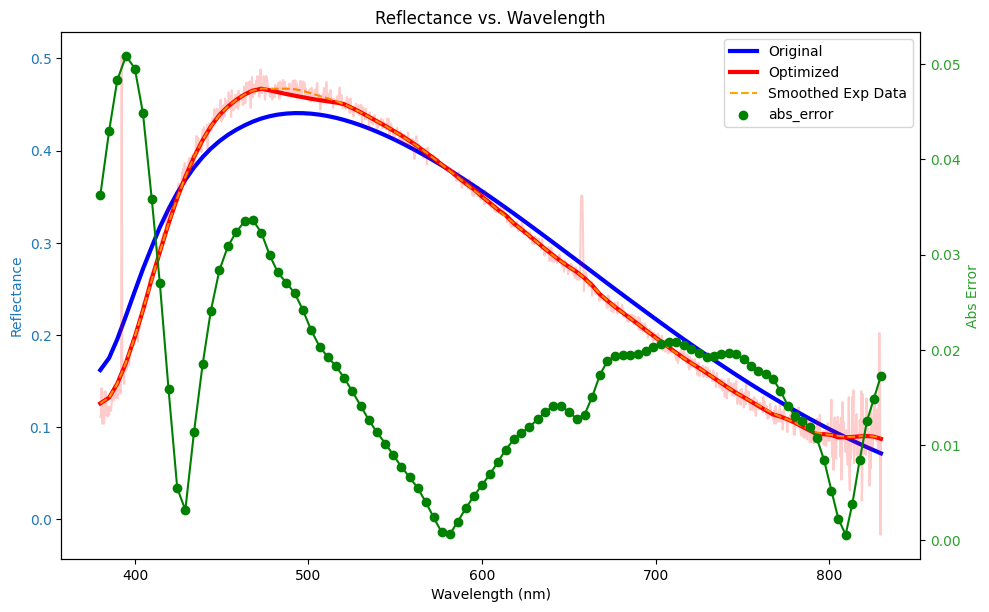

In [10]:
# Now let's plot the results
fig, ax1 = plt.subplots(figsize=(10, 6))

abs_error = abs(original_reflectances - smoothed_data_selected)

color = 'tab:blue'
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Reflectance', color=color)
ax1.plot(wavelengths_selected, original_reflectances, label='Original', color='b', linewidth=3)
ax1.plot(wavelengths_selected, new_reflectances, label='Optimized', linewidth=3, color='r')
ax1.plot(wavelengths_selected, smoothed_data_selected, label='Smoothed Exp Data', linestyle='dashed', color='orange')
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axis that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Abs Error', color=color)
ax2.plot(wavelengths_selected, abs_error, color='g')
ax2.scatter(wavelengths_selected, abs_error, label='abs_error', color='g')
ax2.tick_params(axis='y', labelcolor=color)

# Handle legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

path = r"test_data\spectra\+02_+05.csv"
data = pd.read_csv(path, names=['# lambda', 'reflectance', 'uncertainty', 'raw', 'dark', 'reference', 'fit'], skiprows=13)
data = data.rename(columns={'# lambda': 'wavelength'})
data = data[(data['wavelength'] >= 380) & (data['wavelength'] <= 830)]
ax1.plot(data['wavelength'], data['reflectance'], alpha=0.2, label='Exp Data', color='r')

fig.tight_layout()
plt.title('Reflectance vs. Wavelength')
plt.show()


In [31]:
print(len(wavelengths_selected))
print(len(original_reflectances))
print(len(new_reflectances))
print(len(smoothed_data_selected))

100
100
100
100


In [ ]:
# Convert png into video
# Get the file names from a given directory
folder_path = "plot3"
file_names = sorted((fn for fn in os.listdir(folder_path) if fn.endswith('.png')))

# Create a list of images
images = [imageio.imread(os.path.join(folder_path, fn)) for fn in file_names]

# Save the images as a movie
imageio.mimwrite('movie3.mp4', images, fps=10)  # Adjust FPS as needed


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1200, 600) to (1200, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


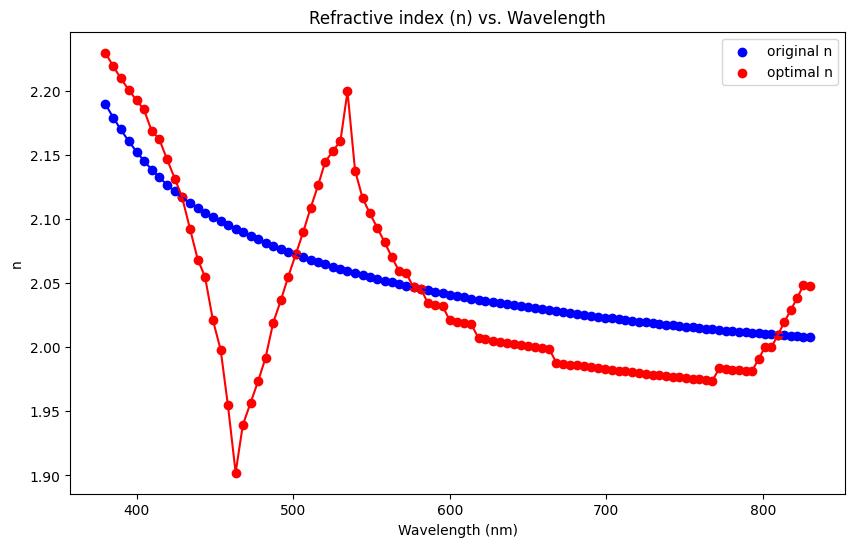

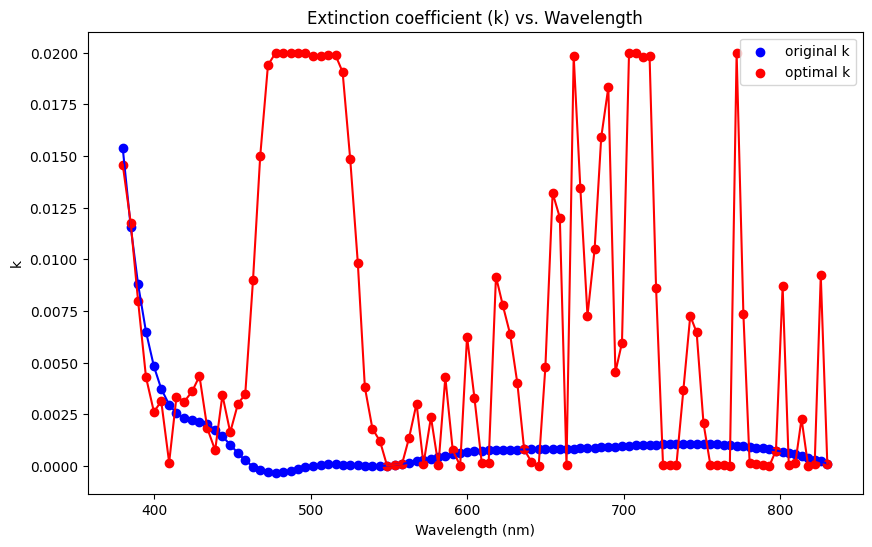

[380.027253 385.100664 389.805713 394.866198 399.919894 404.60648
 409.646914 414.321083 419.348033 424.367905 429.022823 434.028874
 439.027672 443.662866 448.647507 453.62472  458.239714 463.202434
 467.803867 472.751871 477.692158 482.272605 487.19784  492.115183
 496.674169 501.576124 506.470012 511.007062 515.885225 520.407571
 525.269787 530.123648 534.62327  539.460848 544.289895 548.766319
 553.578747 558.382469 562.835221 567.621987 572.058891 576.828478
 581.589071 586.001516 590.744594 595.478504 599.866014 604.582072
 609.288786 613.650889 618.339415 622.684525 627.354642 632.015126
 636.33404  640.975777 645.607707 649.899951 654.512798 659.115663
 663.380762 667.964207 672.211171 676.774975 681.328508 685.547539
 690.081094 694.604203 698.794827 703.297622 707.789796 711.951539
 716.423062 720.565525 725.016176 729.455916 733.568711 737.987242
 742.394689 746.47734  750.863241 755.237883 759.289916 763.642675
 767.674286 772.004941 776.324048 780.324253 784.620919 788.905

In [15]:
# Plot for n
plt.figure(figsize=(10, 6))
plt.plot(wavelengths_selected, layer_igzo111.n_spline_cubic(wavelengths_selected), c='b')
plt.scatter(wavelengths_selected, layer_igzo111.n_spline_cubic(wavelengths_selected), label='original n', c='b')
plt.plot(wavelengths_selected, optimal_ns, c='r')
plt.scatter(wavelengths_selected, optimal_ns, label='optimal n', c='r')
plt.xlabel('Wavelength (nm)')
plt.ylabel('n')
plt.title('Refractive index (n) vs. Wavelength')
plt.legend()
plt.savefig('n_optimal.png', dpi=300)
plt.show()

# Plot for k
plt.figure(figsize=(10, 6))
plt.plot(wavelengths_selected, layer_igzo111.k_spline_cubic(wavelengths_selected), c='b')
plt.scatter(wavelengths_selected, layer_igzo111.k_spline_cubic(wavelengths_selected), label='original k', c='b')
plt.plot(wavelengths_selected, optimal_ks, c='r')
plt.scatter(wavelengths_selected, optimal_ks, label='optimal k', c='r')
plt.xlabel('Wavelength (nm)')
plt.ylabel('k')
plt.title('Extinction coefficient (k) vs. Wavelength')
plt.legend()
plt.savefig('k_optimal.png', dpi=300)
plt.show()

print(wavelengths_selected)
print(optimal_ns)
print(optimal_ns[98])

Try to just sample the points with high error (manually)

In [100]:
# Process the data
# =====================================================
# Load the data
path = r"test_data\spectra\+02_+05.csv"
data = pd.read_csv(path, names=['# lambda', 'reflectance', 'uncertainty', 'raw', 'dark', 'reference', 'fit'], skiprows=13)
data = data.rename(columns={'# lambda': 'wavelength'})

l = 380 #left
r = 830 #right

# Filter data based on wavelength
data = data[(data['wavelength'] >= l) & (data['wavelength'] <= r)]

# Apply the moving median filter to remove sudden spikes
kernel_size = 11 # Adjust as needed
data['reflectance'] = medfilt(data['reflectance'], kernel_size=kernel_size)

# Apply a Gaussian smoothing
sigma = 20 # This is the standard deviation for the Gaussian kernel. Adjust as needed.
smoothed_data = gaussian_filter1d(data['reflectance'], sigma)

# Choose n points from the smoothed data
n_points = 100
indices = np.round(np.linspace(0, len(smoothed_data) - 1, n_points)).astype(int)
wavelengths_selected = data['wavelength'].iloc[indices].values
print(wavelengths_selected)
print(wavelengths_selected.shape)
smoothed_data_selected = smoothed_data[indices]
selected_indices = [0, 3, 8, 13, 17, 23, 29, 40, 50, 61, 71, 81]
wavelengths_selected = np.array([wavelengths_selected[i] for i in selected_indices])
smoothed_data_selected = smoothed_data[selected_indices]

# Define the directory where you want to save the figure
dir_name = "plot4"
# # =====================================================


# Define the multilayer system
# =====================================================
# Create layers
air = ThinFilmLayer("air", 1, 0, l, r)
layer1 = FakeThinFilmLayer(104.0, 0, 0)
layer2 = ThinFilmLayer("sio2", 21.5, 0, l, r)
substrate = ThinFilmLayer("c-Si", 1, 0, l, r)

layer_igzo111 = ThinFilmLayer("igzo_111", 104.0, 10, l, r)
n = layer_igzo111.get_n(wavelengths_selected)
k = layer_igzo111.get_k(wavelengths_selected)
print(n)
print(n.shape)
print(k)
print(k.shape)

# Create multilayer system
multilayer = ThinFilmSystem([air, layer1, layer2, substrate])
# =====================================================


# Define the optimization algorithm
# =====================================================
# Define the function that calculates the reflectance for a given n and k
def calculate_reflectance(n, k, wavelength, multilayer, layer1):
    # Set n and k for layer1
    layer1.set_n(n)
    layer1.set_k(k)
    # Calculate the reflectance
    R, _, _ = multilayer.calculate_RTA_single(wavelength)
    return R

# Define a local search function
def local_search(n_start, k_start, wavelength, smoothed_data, multilayer, layer1, n_step=0.01, k_step=0.0003, n_min=1.5, n_max=2.5, k_min=1e-6, k_max=0.03):
    current_n = n_start
    current_k = k_start
    
    while True:
        R_current = calculate_reflectance(current_n, current_k, wavelength, multilayer, layer1)
        current_error = np.abs(R_current - smoothed_data)

        surrounding_points = [(current_n + i*n_step, current_k + j*k_step) 
                              for i in [-1, 0, 1] for j in [-1, 0, 1] 
                              if not (i == 0 and j == 0) 
                              and n_min <= current_n + i*n_step <= n_max 
                              and k_min <= current_k + j*k_step <= k_max]

        surrounding_errors = [np.abs(calculate_reflectance(n_, k_, wavelength, multilayer, layer1) - smoothed_data)
                              for n_, k_ in surrounding_points]

        if min(surrounding_errors) < current_error:
            min_index = np.argmin(surrounding_errors)
            current_n, current_k = surrounding_points[min_index]
        else:
            break

    return current_n, current_k
# =====================================================


# Calculation
# =====================================================
# Initialize the lists to hold the optimal n and k values
optimal_ns = []
optimal_ks = []

# Initialize the lists to hold the reflectances
original_reflectances = []
new_reflectances = []

# Define the n, k interval
n_min = 1.5
n_max = 2.5
k_min = 1e-6 # Cannot be 0 or there will be an "divide by 0 error"
k_max = 0.03
grid_size = 100
n_values = np.linspace(n_min, n_max, grid_size)
k_values = np.linspace(k_min, k_max, grid_size)

# optimization steps
n_step = np.abs(n_max - n_min) / grid_size
k_step = np.abs(k_max - k_min) / grid_size

# # Create a meshgrid of n and k values
n_values, k_values = np.meshgrid(n_values, k_values)

# Create arrays to store the reflectance values
reflectances = np.zeros((len(wavelengths_selected), len(n_values), len(k_values)))

# Loop over each wavelength
for w, wavelength in enumerate(wavelengths_selected):
    for i in range(n_values.shape[0]):
        for j in range(n_values.shape[1]):
            # Set n and k for layer1
            layer1.set_n(n_values[i, j])
            layer1.set_k(k_values[i, j])
            
            # Calculate the reflectance
            R, _, _ = multilayer.calculate_RTA_single(wavelength)

            # Store the reflectance value
            reflectances[w, i, j] = R
            
    # Store the reflectances for the original n, k values
    layer1.set_n(n[w])
    layer1.set_k(k[w])
    R, _, _ = multilayer.calculate_RTA_single(wavelength)
    original_reflectances.append(R)

    # Optimization
    optimal_n, optimal_k = local_search(n[w], k[w], wavelength, smoothed_data_selected[w], multilayer, layer1, n_step, k_step, n_min, n_max, k_min, k_max)
    optimal_ns.append(optimal_n)
    optimal_ks.append(optimal_k)

    # Use the optimal n, k to calculate the reflectance
    layer1.set_n(optimal_n)
    layer1.set_k(optimal_k)
    R, _, _ = multilayer.calculate_RTA_single(wavelength)
    new_reflectances.append(R)
    # =====================================================

    # Plot
    # =====================================================
    # Create a new figure for this wavelength
    fig = plt.figure(figsize=(12, 6))

    fig.subplots_adjust(wspace=0.3)  # Adjust this value as needed
    
    # Add a subplot for the reflectance
    ax1 = fig.add_subplot(121, projection='3d')

    # Plot the reflectance as a function of n and k
    surface = ax1.plot_surface(n_values, k_values, reflectances[w], cmap='viridis', alpha=0.6)

    # Add a plane for the experimental reflectance
    ax1.plot_surface(n_values, k_values, smoothed_data_selected[w]*np.ones_like(reflectances[w]), color='r', alpha=0.3)

    # Set the title and labels
    ax1.set_title('Wavelength: {} nm'.format(wavelength))
    ax1.set_xlabel('n')
    ax1.set_ylabel('k')
    ax1.set_zlabel('R_cal')

    # Set the viewpoint for ax1
    elevation_angle = 30  # adjust to your preference
    azimuthal_angle = 225  # adjust to your preference

    # Add a subplot for the squared error
    ax2 = fig.add_subplot(122)

    # Calculate the error
    abs_error = np.abs(reflectances[w] - smoothed_data_selected[w])

    # Plot the squared error as a function of n and k
    im = ax2.imshow(abs_error, extent=(n_min, n_max, k_min, k_max), aspect='auto')

    # Plot the (n, k) from database
    ax2.scatter(n[w], k[w], c='r')
    
    # Plot the optimal (n, k) from optimization
    ax2.scatter(optimal_n, optimal_k, c='b')  # Add this line

    # Create a colorbar for the heatmap
    # Get the position of ax2
    pos = ax2.get_position()
    # Create a new set of axes for the colorbar at the right of ax2
    # The arguments to fig.add_axes are [left, bottom, width, height]
    cbar_ax = fig.add_axes([pos.x1+0.01, pos.y0, 0.02, pos.height])

    # Create a colorbar in the new axes
    cbar = fig.colorbar(im, cax=cbar_ax)

    # Set the label for the colorbar
    cbar.set_label('Abs(R_cal - R_exp)')

    # Set the title and labels
    ax2.set_title('Abs Error at Wavelength: {} nm'.format(wavelength))
    ax2.set_xlabel('n')
    ax2.set_ylabel('k')

    # save the plot
    plt.savefig(os.path.join(dir_name, f"{wavelength}.png"))
    plt.close()
    # =====================================================


[380.027253 385.100664 389.805713 394.866198 399.919894 404.60648
 409.646914 414.321083 419.348033 424.367905 429.022823 434.028874
 439.027672 443.662866 448.647507 453.62472  458.239714 463.202434
 467.803867 472.751871 477.692158 482.272605 487.19784  492.115183
 496.674169 501.576124 506.470012 511.007062 515.885225 520.407571
 525.269787 530.123648 534.62327  539.460848 544.289895 548.766319
 553.578747 558.382469 562.835221 567.621987 572.058891 576.828478
 581.589071 586.001516 590.744594 595.478504 599.866014 604.582072
 609.288786 613.650889 618.339415 622.684525 627.354642 632.015126
 636.33404  640.975777 645.607707 649.899951 654.512798 659.115663
 663.380762 667.964207 672.211171 676.774975 681.328508 685.547539
 690.081094 694.604203 698.794827 703.297622 707.789796 711.951539
 716.423062 720.565525 725.016176 729.455916 733.568711 737.987242
 742.394689 746.47734  750.863241 755.237883 759.289916 763.642675
 767.674286 772.004941 776.324048 780.324253 784.620919 788.905

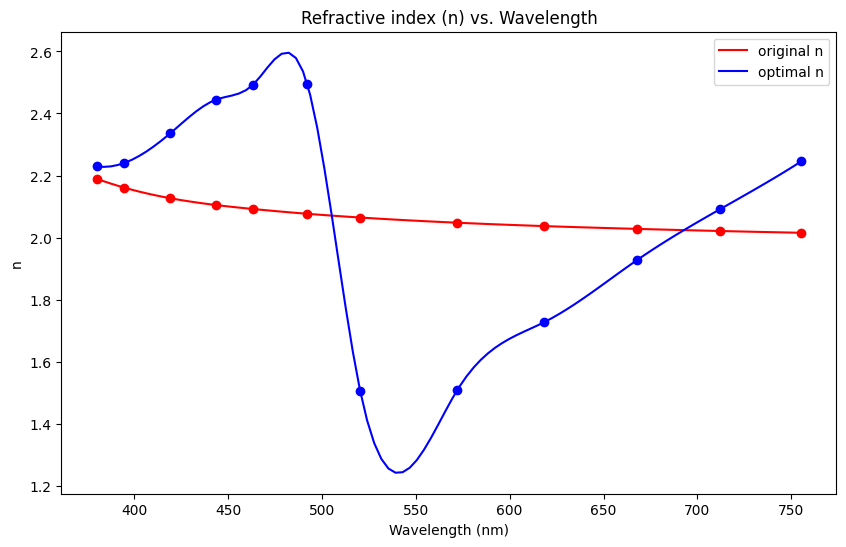

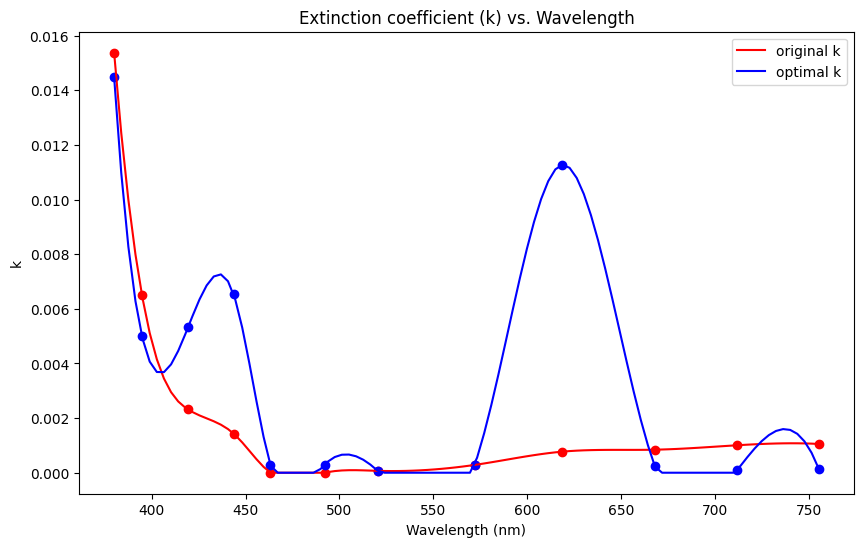

In [101]:
wavelength_range = np.linspace(min(wavelengths_selected), max(wavelengths_selected), 100)

# Plot for n
original_n_spline = CubicSpline(wavelengths_selected, n)
optimal_n_spline = CubicSpline(wavelengths_selected, optimal_ns)

# Constrain the value to be larger than 0
original_n_spline = np.maximum(original_n_spline(wavelength_range), 0)
optimal_n_spline = np.maximum(optimal_n_spline(wavelength_range), 0)

plt.figure(figsize=(10, 6))
plt.plot(wavelength_range, original_n_spline, label='original n', c='r')
plt.scatter(wavelengths_selected, n, c='r')
plt.plot(wavelength_range, optimal_n_spline, label='optimal n', c='b')
plt.scatter(wavelengths_selected, optimal_ns, c='b')
plt.xlabel('Wavelength (nm)')
plt.ylabel('n')
plt.title('Refractive index (n) vs. Wavelength')
plt.legend()
plt.savefig(r'plot4\n_optimal.png', dpi=300)
plt.show()

# Plot for k
original_k_spline = CubicSpline(wavelengths_selected, k)
optimal_k_spline = CubicSpline(wavelengths_selected, optimal_ks)

# Constrain the value to be larger than 0
original_k_spline = np.maximum(original_k_spline(wavelength_range), 0)
optimal_k_spline = np.maximum(optimal_k_spline(wavelength_range), 0)

plt.figure(figsize=(10, 6))
plt.plot(wavelength_range, original_k_spline, label='original k', c='r')
plt.scatter(wavelengths_selected, k, c='r')
plt.plot(wavelength_range, optimal_k_spline, label='optimal k', c='b')
plt.scatter(wavelengths_selected, optimal_ks, c='b')
plt.xlabel('Wavelength (nm)')
plt.ylabel('k')
plt.title('Extinction coefficient (k) vs. Wavelength')
plt.legend()
plt.savefig(r'plot4\k_optimal.png', dpi=300)
plt.show()

[380.027253   383.81725936 387.60726573 391.39727209 395.18727845
 398.97728482 402.76729118 406.55729755 410.34730391 414.13731027
 417.92731664 421.717323   425.50732936 429.29733573 433.08734209
 436.87734845 440.66735482 444.45736118 448.24736755 452.03737391
 455.82738027 459.61738664 463.407393   467.19739936 470.98740573
 474.77741209 478.56741845 482.35742482 486.14743118 489.93743755
 493.72744391 497.51745027 501.30745664 505.097463   508.88746936
 512.67747573 516.46748209 520.25748845 524.04749482 527.83750118
 531.62750755 535.41751391 539.20752027 542.99752664 546.787533
 550.57753936 554.36754573 558.15755209 561.94755845 565.73756482
 569.52757118 573.31757755 577.10758391 580.89759027 584.68759664
 588.477603   592.26760936 596.05761573 599.84762209 603.63762845
 607.42763482 611.21764118 615.00764755 618.79765391 622.58766027
 626.37766664 630.167673   633.95767936 637.74768573 641.53769209
 645.32769845 649.11770482 652.90771118 656.69771755 660.48772391
 664.2777302

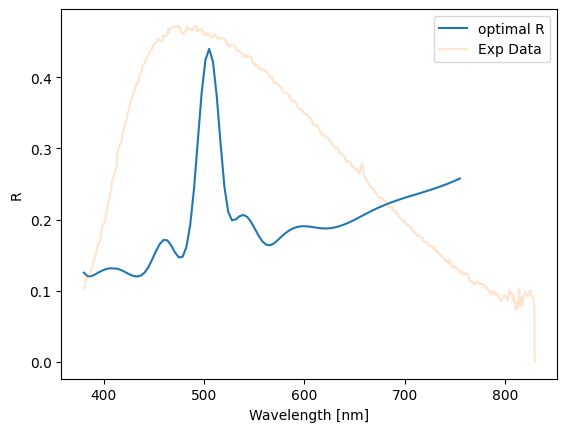

In [104]:
print(wavelength_range)
print(len(wavelength_range))
optimal_R = []
for w in range(len(wavelength_range)):
  layer1.set_n(optimal_n_spline[w])
  layer1.set_k(optimal_k_spline[w])
  multilayer = ThinFilmSystem([air, layer1, layer2, substrate])
  R, _, _ = multilayer.calculate_RTA_single(wavelength_range[w])
  optimal_R.append(R)

plt.plot(wavelength_range, optimal_R, label='optimal R')
plt.plot(data['wavelength'], data['reflectance'], alpha=0.2, label='Exp Data')
plt.xlabel('Wavelength [nm]')
plt.ylabel('R')
plt.legend()
plt.show()